# Data Analysis and Prediction on Among Us Dataset
#### Fall 2021 DS-1001 Capstone Project
#### Chloe Zheng cz1300, Jason Wang jw7383 , Xu Han xh852

## Data Preprocessing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Import Data and concatenate into one Dataframe
# Add User Id
files = []
for i in range(29):
    tempdf = pd.read_csv(f'data/User{i+1}.csv', delimiter = ',')
    tempdf['User'] = i
    files.append(tempdf)
df = pd.concat(files, ignore_index = True)
df.head()

,Game Completed Date,Team,Outcome,Task Completed,All Tasks Completed,Murdered,Imposter Kills,Game Length,Ejected,Sabotages Fixed,Time to complete all tasks,Rank Change,Region/Game Code,User
0,12/13/2020 at 1:26:56 am EST,Crewmate,Win,3,No,Yes,-,07m 04s,No,2.0,-,++,NA / WYMSBF,0
1,12/13/2020 at 1:17:42 am EST,Crewmate,Loss,7,Yes,No,-,16m 21s,No,1.0,09m 48s,--,NA / WYMSBF,0
2,12/13/2020 at 12:57:47 am EST,Crewmate,Win,3,No,No,-,11m 33s,No,0.0,-,++,NA / WYMSBF,0
3,12/13/2020 at 12:41:55 am EST,Imposter,Win,-,-,-,2,08m 05s,No,NaN,-,+++,Europe / QIRTNF,0
4,12/13/2020 at 12:30:37 am EST,Crewmate,Loss,4,No,No,-,05m 10s,No,0.0,-,---,Europe / QIRTNF,0


In [3]:
# List column features
df.dtypes

Game Completed Date            object
Team                           object
Outcome                        object
Task Completed                 object
All Tasks Completed            object
Murdered                       object
Imposter Kills                 object
Game Length                    object
Ejected                        object
Sabotages Fixed               float64
Time to complete all tasks     object
Rank Change                    object
Region/Game Code               object
User                            int64
dtype: object

In [4]:
# Reformat Data - time and region
df[['Task Completed', 'Imposter Kills']] = df[['Task Completed', 'Imposter Kills']].apply(pd.to_numeric, errors = 'coerce')
df['Region'] = df['Region/Game Code'].str.extract(r'^(.*?)/')
df['Region'].value_counts()
df['Game Length'] = df['Game Length'].apply(pd.to_timedelta)
df['Game Length'] = df['Game Length'] / np.timedelta64(1, 's')
df['Time to complete all tasks'] = df['Time to complete all tasks'].apply(pd.to_timedelta, errors = 'coerce')
df['Time to complete all tasks'] = df['Time to complete all tasks'] / np.timedelta64(1, 's')

In [5]:
# Create Dataframe for ONLY Crewmate data
crewmate = df[['Team',
               'Outcome',
               'Task Completed',
               'All Tasks Completed',
               'Murdered',
               'Game Length',
               'Ejected',
              'Sabotages Fixed',
              'Region',
              'User']][df['Team'] == 'Crewmate']
crewmate.head()

,Team,Outcome,Task Completed,All Tasks Completed,Murdered,Game Length,Ejected,Sabotages Fixed,Region,User
0,Crewmate,Win,3.0,No,Yes,424.0,No,2.0,NA,0
1,Crewmate,Loss,7.0,Yes,No,981.0,No,1.0,NA,0
2,Crewmate,Win,3.0,No,No,693.0,No,0.0,NA,0
4,Crewmate,Loss,4.0,No,No,310.0,No,0.0,Europe,0
5,Crewmate,Loss,7.0,Yes,Yes,982.0,No,0.0,Europe,0


In [6]:
# Reformat Data - change columns into binary
crewmate['Outcome'] = crewmate['Outcome'].replace(['Loss', 'Win'],[0, 1])
crewmate['All Tasks Completed'] = crewmate['All Tasks Completed'].replace(['No', 'Yes'],[0, 1])
crewmate['Murdered'] = crewmate['Murdered'].replace(['No', 'Yes'],[0, 1])
crewmate['Ejected'] = crewmate['Ejected'].replace(['No', 'Yes'],[0, 1])
crewmate['Region'] = crewmate['Region'].replace(['NA ', 'Europe '],[0, 1])
crewmate.head()

,Team,Outcome,Task Completed,All Tasks Completed,Murdered,Game Length,Ejected,Sabotages Fixed,Region,User
0,Crewmate,1,3.0,0,1,424.0,0,2.0,0,0
1,Crewmate,0,7.0,1,0,981.0,0,1.0,0,0
2,Crewmate,1,3.0,0,0,693.0,0,0.0,0,0
4,Crewmate,0,4.0,0,0,310.0,0,0.0,1,0
5,Crewmate,0,7.0,1,1,982.0,0,0.0,1,0


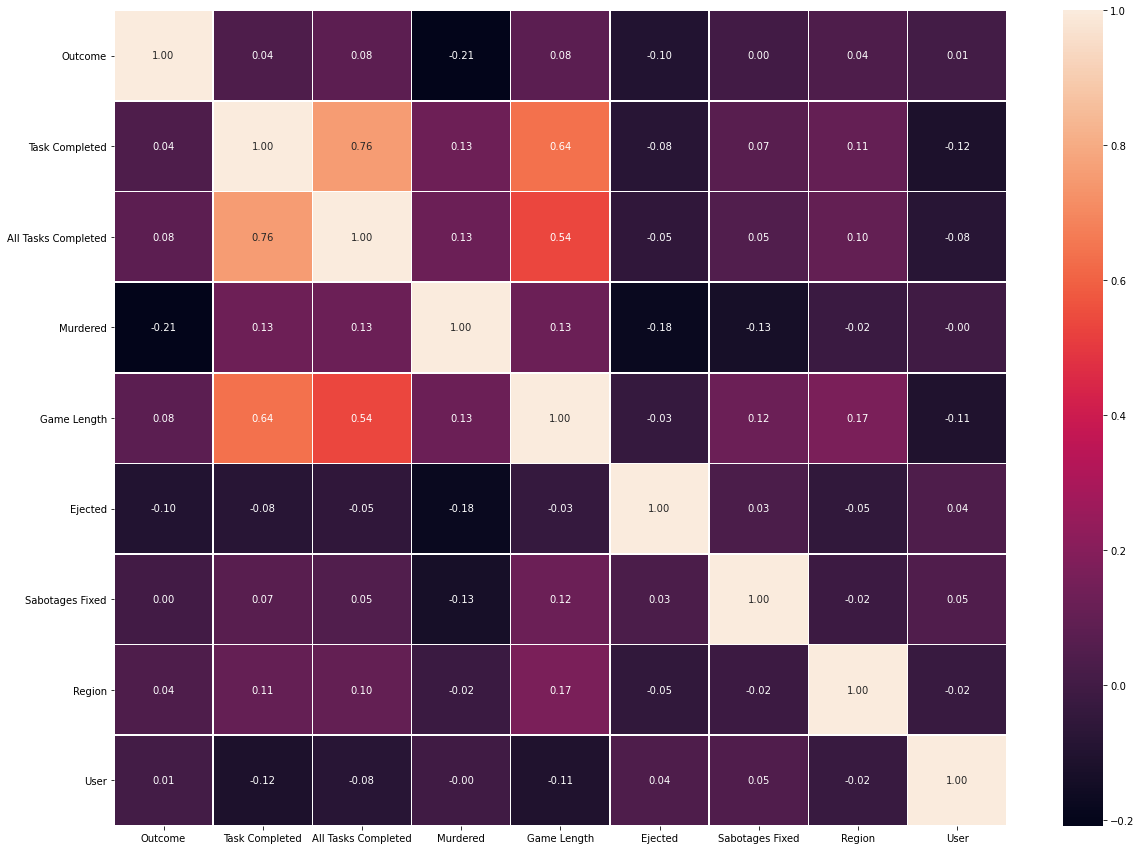

In [7]:
# Analyze Correlation Matrix for correlated features
%matplotlib inline
corrlation_matrix = crewmate.corr()
fig, ax = plt.subplots(figsize = (20, 15))
ax = sns.heatmap(corrlation_matrix,
                annot = True,
                linewidths = 0.5,
                fmt = ".2f")

In [8]:
# Based on Correlation Matrix, 'All Tasks Completed' is highly correlated with 'Tasks Completed'
#Drop 'All Tasks Completed' to resolve multicollinarity
crewmate = crewmate.drop(['All Tasks Completed'], axis =1)
crewmate.head()

,Team,Outcome,Task Completed,Murdered,Game Length,Ejected,Sabotages Fixed,Region,User
0,Crewmate,1,3.0,1,424.0,0,2.0,0,0
1,Crewmate,0,7.0,0,981.0,0,1.0,0,0
2,Crewmate,1,3.0,0,693.0,0,0.0,0,0
4,Crewmate,0,4.0,0,310.0,0,0.0,1,0
5,Crewmate,0,7.0,1,982.0,0,0.0,1,0


## Hypothesis Testing

#### Null Hypothesis: Crewmates who finish more tasks do not necessarily win more often.

In [9]:
from scipy import stats
from scipy.stats import t

In [10]:
# t-test
avg_task_completed = crewmate.groupby(by = 'User')['Task Completed'].mean()
avg_wins = crewmate.groupby(by = 'User')['Outcome'].mean()

thresh = avg_task_completed.mean() #Setting a threshold to separate data into two groups 
less_tasks = avg_wins[avg_task_completed < thresh]
greater_tasks = avg_wins[avg_task_completed >= thresh]

t1, p1 = stats.ttest_ind(less_tasks, greater_tasks, alternative='less') #Calculate t-statstic and p-value
print("p-value:", p1)
print("t-statistic:", t1)

p-value: 0.05237999155491819
t-statistic: -1.6786449499637606


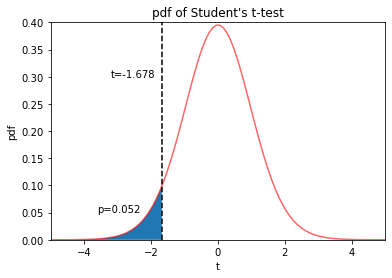

In [11]:
# Graph t-distribution with our results
degree = 27
fig = plt.figure()
x = np.linspace(t.ppf(0.00001, degree),
                t.ppf(0.99999, degree), 100)
plt.plot(x, t.pdf(x, degree),'r-', alpha=0.6, label='t pdf')
plt.axvline(t1, color = 'black', ls = '--')
plt.xlabel('t')
plt.ylabel('pdf')
plt.title("pdf of Student's t-test")
plt.xlim(-5,5)
plt.ylim(0,.4)

def f(x):
    return t.pdf(x, 27)

section = np.linspace(-5,t1,100)
plt.fill_between(section,f(section))
plt.annotate('t=-1.678', (-3.2,.3))
plt.annotate('p=0.052', (-3.6,.05))

plt.show()

## Logistic Regression

#### Predictors: Crewmate stats -(1) task completed (2) murdered (3) game length (4) ejected (5) sabotages fixed (6) region
#### Outcome: Win or loss

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

In [13]:
# Train/Test split functions
# Goal: split data such that each unique user's data is ONLY in either the train or test.
#     Since the amount of games played per user is NOT consistent, use the subset sum dynamic programming method to
#     find a subset that satifies the target ratio
#     REFERENCE: https://levelup.gitconnected.com/dynamic-programming-subset-sum-c386126621cd

def user_train_valid_split(users_i,valid_ratio,possible=False):
    n = sum(users_i)
    target = int(np.floor(valid_ratio*n))
    while not possible:
        possible, validation_indices = user_split(users_i,target)
        target -= 1
    training_indices = [i for i in range(len(users_i)) if i not in validation_indices]
    return training_indices, validation_indices

def user_split(users_i,target):  
    n = len(users_i)
    solution = [[False for j in range(int(target+1))] for i in range(n+1)]
    # base cases
    for i in range(n):
        solution[i][0] = True
    # other cases
    for i in range(1,n+1):
        for j in range(1,target+1):
            solution[i][j] = solution[i-1][j]
            if(solution[i][j] == False and j >= users_i[i-1]):
                solution[i][j] = solution[i][j] or solution[i-1][j-users_i[i-1]]
    # check if the subset sum is possible
    possible = solution[len(users_i)][target]
    subset = []
    if not possible: return possible, subset
    # return the subset solution if one exists
    y = len(users_i)
    x = target
    while x != 0:
        if solution[y-1][x] == False:
            subset.append(y-1)
            x -= users_i[y-1]
        else: 
            y -= 1
    return possible, subset

In [14]:
# Split data
crewmates_i = list(crewmate["User"].value_counts(sort = False))
test_ratio = .25
training_indices, test_indices = user_train_valid_split(crewmates_i,test_ratio)

train_data = crewmate.loc[crewmate['User'].isin(training_indices)]
test_data = crewmate.loc[crewmate['User'].isin(test_indices)]
train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

# Check
train_sum = sum([crewmates_i[i] for i in training_indices])
test_sum = sum([crewmates_i[i] for i in test_indices])
print("expected ratio: {}, actual: {}".format(test_ratio, test_sum/(train_sum+test_sum)))

expected ratio: 0.25, actual: 0.2498580352072686


Training data...
Testing model...
AUC score: 0.6136017272034544


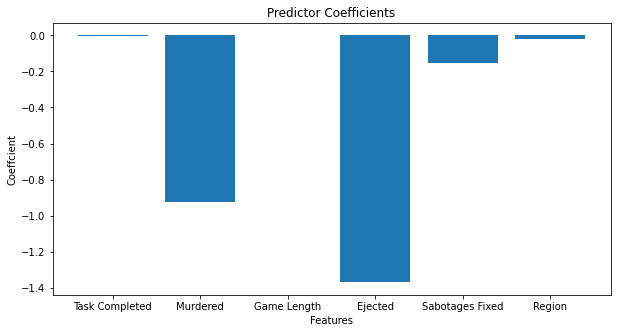

In [15]:
# Train data
print("Training data...")
X_train = train_data.drop(["Outcome", "Team", "User"], axis=1)
y_train = train_data["Outcome"]
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
coefs = clf.coef_[0]

# Test data
print("Testing model...")
X_test = test_data.drop(["Outcome", "Team", "User"], axis=1)
y_true = test_data["Outcome"]
y_predict = clf.predict(X_test)

auc = roc_auc_score(y_true, y_predict)
print("AUC score:", auc)

# Analyze coefficients
plt.figure(figsize=(10,5))
plt.bar(X_train.columns, coefs)
plt.xlabel("Features")
plt.ylabel("Coeffcient")
plt.title("Predictor Coefficients")
plt.show()

## Multiple Linear Regression

#### Predictors: Grouped by user, crewmate stats - (1) avg winrate (2) avg number of task completed (3) number of times being crewmate (4) avg murdered rate (5) avg ejected rate (6) avg sabotages fixed (7) avg game length
#### Outcome: Grouped by user, imposter win rate

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso, Ridge

In [17]:
# Prepare X data
users = pd.DataFrame()

users['avg_winrate'] = crewmate.groupby('User')['Outcome'].mean()
users['avg_task_comp'] = crewmate.groupby('User')['Task Completed'].mean()
users['num_time_crew'] = crewmate['User'].value_counts(sort=False)
users['avg_murdered_rate'] = crewmate.groupby('User')['Murdered'].mean()
users['avg_ejected_rate'] = crewmate.groupby('User')['Ejected'].mean()
users['avg_sabotaged_fixed'] = crewmate.groupby('User')['Sabotages Fixed'].mean()
users['avg_game_length'] = crewmate.groupby('User')['Game Length'].mean()

users.head()

,avg_winrate,avg_task_comp,num_time_crew,avg_murdered_rate,avg_ejected_rate,avg_sabotaged_fixed,avg_game_length
User,,,,,,,
0,0.571429,6.142857,77,0.597403,0.012987,0.389610,741.363636
1,0.480519,5.818182,77,0.467532,0.051948,0.675325,636.623377
2,0.485294,5.352941,68,0.426471,0.029412,0.661765,683.514706
3,0.493827,4.135802,81,0.419753,0.061728,0.444444,457.790123
4,0.483871,4.806452,31,0.580645,0.000000,0.451613,708.935484


In [18]:
# Prepare y data
imp = df[df['Team']=='Imposter']
imp['Outcome'] = imp['Outcome'].replace(['Loss', 'Win'], [0,1])
imp.head();
target = imp.groupby('User')['Outcome'].mean()

In [19]:
# Split data using built in function
X_train, X_test, y_train, y_test = train_test_split(users, 
                                                    target, 
                                                    test_size=0.2,
                                                   random_state=42)

alphas: [0.1, 1, 10, 100, 1000, 10000]
train error: [0.014062169510723983, 0.017047862926834297, 0.01827747483360156, 0.01958643129097493, 0.019990264530667243, 0.02025152153290846]
test error: [0.03132902718349165, 0.02545519035774095, 0.024070668624244177, 0.023656652997387576, 0.023640890671047743, 0.02383709743361236]


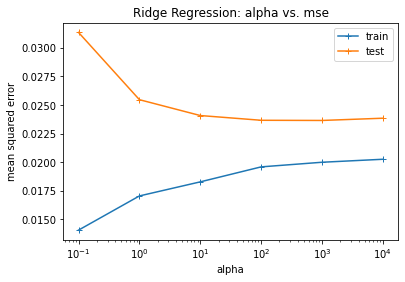

In [20]:
# Ridge
alphas = [0.1, 1, 10, 100, 1000,10000]
train_error, test_error = [], []

for alpha in alphas:
    clf = Ridge(alpha=alpha)
    clf.fit(X_train, y_train)
    pers_train_predict = clf.predict(X_train)
    pers_test_predict = clf.predict(X_test)
    train_error.append(mean_squared_error(y_train, pers_train_predict))
    test_error.append(mean_squared_error(y_test,pers_test_predict ))
    
print("alphas: {}\ntrain error: {}\ntest error: {}".format(alphas,train_error,test_error))

plt.plot(alphas, train_error, '-+', label='train')
plt.plot(alphas, test_error,'-+', label='test')
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('mean squared error')
plt.title('Ridge Regression: alpha vs. mse')
plt.legend()
plt.show()

alphas: [0.001, 0.01, 0.1, 1]
train error: [0.013351083045980108, 0.01816712966506992, 0.020055568714751525, 0.02111504369772632]
test error: [0.034129538966013, 0.024198806614650847, 0.0237210801351239, 0.02512092489759861]


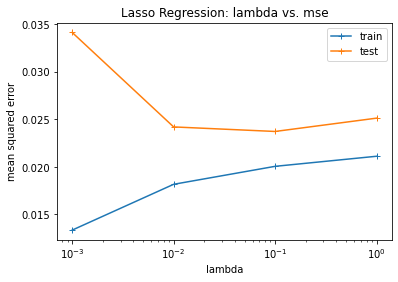

In [21]:
# Lasso
lbds = [1e-3, 1e-2, 1e-1, 1]
train_error_lasso, test_error_lasso = [], []

for lbd in lbds:
    lasso = Lasso(alpha=lbd)
    lasso.fit(X_train, y_train)
    
    pers_train_predict = lasso.predict(X_train)
    pers_test_predict = lasso.predict(X_test)
    train_error_lasso.append(mean_squared_error(y_train, pers_train_predict))
    test_error_lasso.append(mean_squared_error(y_test,pers_test_predict ))

print("alphas: {}\ntrain error: {}\ntest error: {}".format(lbds,train_error_lasso,test_error_lasso))

plt.plot(lbds, train_error_lasso, '-+', label='train')
plt.plot(lbds, test_error_lasso,'-+', label='test')
plt.xscale('log')
plt.xlabel('lambda')
plt.ylabel('mean squared error')
plt.title('Lasso Regression: lambda vs. mse')
plt.legend()
plt.show()

In [22]:
#Update Lasso with best parameter 0.1
best_lasso = Lasso(alpha=0.1)
#Fit the dataset into the new model
best_lasso.fit(X_train, y_train)
#Make predictions
predict = best_lasso.predict(users)
#Put real outcomes and predictions together
lasso_result = pd.DataFrame()
lasso_result['outcome'] = target
lasso_result['predicted'] = predict
lasso_result.head(10).T

User,0,1,2,3,4,5,6,7,8,9
outcome,0.608696,0.434783,0.347826,0.368421,0.750000,0.571429,0.533333,0.578947,0.571429,0.541667
predicted,0.518597,0.521453,0.531285,0.521390,0.576269,0.507775,0.509597,0.512995,0.515077,0.525964
